<a href="https://colab.research.google.com/github/mequanent/Social-Networks/blob/main/SN_Link_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mequanent Argaw Muluneh** \
**Social Networks Homework from Lab2 (Link Prediction)** \

**December 16 - 2022** \
\
*I did it using Colab and the tables maybe viewed better in Colab.

In [1]:
#@title Import Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
import pydot
import time
%matplotlib inline

# Lab Practice

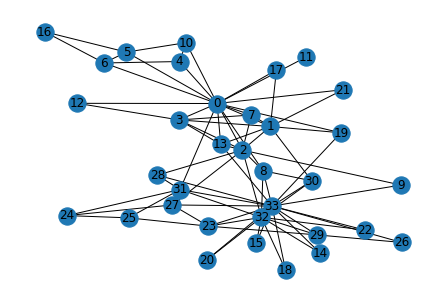

In [2]:
#@title Load the graph
G = nx.karate_club_graph()

# visualize the graph
nx.draw(G, with_labels = True)

In [ ]:
#@title Some Graph Descriptions
print("Total No. of nodes: ", G.number_of_nodes()) 
print("Total No. of edges: ", G.number_of_edges())
print(list(nx.nodes(G))) # list of nodes
print(list(G.neighbors(0))) # list of neighbors of a node, 0 for showcase

Total No. of nodes:  34
Total No. of edges:  78
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]


## User Defined Similarity Coefficients 

In [3]:
#@title Local Clustering Coefficient 

# Addition is used in the local clustering 
def get_LCC(g):
  LCC = dict()
  for i in g.nodes:
    triangles = nx.triangles(g, i)
    k = nx.degree(g, i)
    lcc = 0
    if k > 1:
      lcc = (2* triangles) /(k*(k-1))
    LCC[i] = lcc

  lccs = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        lccs.append((u, v, LCC[u] + LCC[v])) 
  
  return lccs 

In [7]:
#@title SimRank

# get count of neighbors for a node for |I(a)| and |I(b)|
def num_neighbors(g, a):
  neighbors = [i for i in g.neighbors(a)]
  return len(neighbors)

# find the sum of the similarity of neighbors of a and b 
def similarity_sum(g, a, b, s):
  sum = 0.0
  for i in g.neighbors(a):
    for j in g.neighbors(b):
      sum += s[i, j] 
  return sum 

def sim_rank_per_iter(g, K, C):
  #K  maximum iterations 
  #C  importance factor of the similarity b/n neighbors of a and b
  
  n = len(g.nodes) # number of nodes
  # initialize all simiarity values with 1.0 for a==b and 0.0 otherwise
  S = np.eye(n, dtype=np.float16) # S -> nxn similarity matrix

  for k in range(K): 
    s = S.copy() # keep the previous similarity matrix to use for the next
    for a in range(n): 
      I_a = num_neighbors(g, a) 
      for b in range(n): 
        I_b = num_neighbors(g, b) 
        if a == b:
          S[a, b] = 1.0
        elif I_a == 0 or I_b == 0: # avoid division by zero 
            S[a, b] = 0 
        else:
          S[a, b] = C  * similarity_sum(g, a, b, s)/ (I_a*I_b) 
           
  return S  

def simRank(g):
  # K = 5, C = 0.8
  similarity_matrix = sim_rank_per_iter(g, K = 5, C = 0.8)
  simRanks = []
  for u in g.nodes:
    for v in g.nodes:
      if u not in nx.neighbors(g, v) and u < v:
        simRanks.append((u, v, similarity_matrix[u, v])) 
  
  return simRanks 

In [8]:
#@title Edges removing function 

# This code has changed from the lab to make it function for later use
def remove_edges(graph, edgelist):
  # sort the edges to be removed in descending order
  edgelist = sorted(edgelist, reverse=True) 
  removed_edges = list()
  for i in edgelist:
      u = list(graph.edges)[i][0]
      v = list(graph.edges)[i][1]
      removed_edges.append([u,v])
      graph.remove_edge(u,v)
  return removed_edges

In [9]:
edge_to_remove = [75, 51, 18]
removed_edges = remove_edges(G, edge_to_remove)
k = len(removed_edges)

## Sort the coefficients 

In [10]:
#@title Descending sort of Coefficients

# to avoid the same statement for all similarity coefficients 
def sort_coef(coefficient):
  return sorted(coefficient, key=lambda tup: tup[2], reverse=True)

In [11]:
#@title Get the coefficients and sort them

#@title cn, jaccard, pref_attachment, adamic 
cn = nx.common_neighbor_centrality(G) # common neighbor 
jaccard = nx.jaccard_coefficient(G) 
pref_attachment = nx.preferential_attachment(G) 
adamic = nx.adamic_adar_index(G) 
lccs =  get_LCC(G) 
simRanks = simRank(G) 
#simRanks = nx.simrank_similarity(G, source=None, target=None,
#                                 importance_factor=0.8, max_iterations=5)
#simRanks = nx.simrank_similarity(G, importance_factor=0.8)

# sort the coefficients 
cn = sort_coef(cn)
jaccard = sort_coef(jaccard)
adamic = sort_coef(adamic)
pref_attachment = sort_coef(pref_attachment)
lccs= sort_coef(lccs)
simRanks = sort_coef(simRanks)

## Evaluation Metrics

These metrics are used in the Homework section and need to be run before running the homework part. 

In [12]:
#@title Mean Rank (MR)
def MR(sorted_tuple, removed_edges):
  rank = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
          rank += idx
      idx += 1
  return rank/k

In [13]:
#@title Mean Reciprocal Rank (MRR)
def MRR(sorted_tuple, removed_edges):
  rank = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
          rank += 1/(idx+1) # 1/(idx +1)
      idx += 1
  return rank/k

In [14]:
#@title Hit@N
def hitN(sorted_tuple, removed_edges, N):
  hits = 0
  idx = 0
  for u,v,val in sorted_tuple:
      if [u,v] in removed_edges:
        if idx < N:
          hits += 1 
      idx += 1
  return hits

In [15]:
#@title Display Function

# display metrics and the time to compute all of them together
def display_metrics(coef, removed_edges, title, N):
  start = time.time()
  print(title)
  print("MR: ", MR(coef, removed_edges))
  print("MRR: ", MRR(coef, removed_edges))
  print(f"Hit@{N}:  {hitN(coef, removed_edges, N)}")
  end = time.time()
  print("Time %f seconds" % (end-start))
  print("\n")

In [16]:
#@title Display metrics of coefficients
# sorted_cn, sorted_jaccard, sorted_adamic, sorted_pref_attachment, sorted_lcc
display_metrics(cn, removed_edges, "Common Neighbor", 100)
display_metrics(jaccard, removed_edges, "Jaccard Coefficient", 100)
display_metrics(adamic, removed_edges, "Adamic/Adar", 100)
display_metrics(pref_attachment, removed_edges, "Preferential Attachment ", 100)
display_metrics(lccs, removed_edges, "Local Clustering Coefficient with Addition", 100)
display_metrics(simRanks, removed_edges, "SimRank", 100) 

Common Neighbor
MR:  160.0
MRR:  0.11390640802405506
Hit@100:  1
Time 0.005450 seconds


Jaccard Coefficient
MR:  184.33333333333334
MRR:  0.009301753947423238
Hit@100:  1
Time 0.000811 seconds


Adamic/Adar
MR:  131.0
MRR:  0.03173144573144573
Hit@100:  1
Time 0.006922 seconds


Preferential Attachment 
MR:  74.0
MRR:  0.029221522292215224
Hit@100:  2
Time 0.000688 seconds


Local Clustering Coefficient with Addition
MR:  370.3333333333333
MRR:  0.0032556723687336662
Hit@100:  0
Time 0.000684 seconds


SimRank
MR:  179.0
MRR:  0.006456824828917852
Hit@100:  1
Time 0.010582 seconds




# Home work

Functions defining evaluation metrics and libraries are used from above cells. 

In [33]:
#@title Global variables 
metrics = ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
coefficient_indices = ['CN', 'Jaccard', 'Pref_attachment', 'Adamic', 'LCC', 'simRanks']

In [32]:
#@title Metrics of Coefficients

def metrics_per_coef(coef, removed_edges):
  start = time.time()

  mr = MR(coef, removed_edges) # MR
  mrr = MRR(coef, removed_edges) # MRR
  hit50 = hitN(coef, removed_edges, 50) # Hit@50
  hit100 = hitN(coef, removed_edges, 100) # Hit@100
  hit300 = hitN(coef, removed_edges, 300) # Hit@300
  total_time = time.time() - start # time

  return mr, mrr, hit50, hit100, hit300, total_time

In [31]:
#@title Avg of 10 iterations for each k = {1, 5, 10, 50}

def get_coef_metrics(k):
  '''This function collects the metrics of each similarity coefficient into a 
  data frame. For every 10 iterations, it adds the metrics to their previous
  value in the data frame and then returns the average of the sum. '''
  df = pd.DataFrame(0.0, index=coefficient_indices, columns=metrics) 

  for i in range(10): 
    g = nx.karate_club_graph() # reload the graph to include the removed edges

    # generate non-repeating random integers in the range of num_egdes
    edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
    
    # the edges to be removed are sorted in the remove_edges() function
    removed_edges = remove_edges(g, edges_to_remove) 

    # get and sort the similarity coefficients 
    cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
    jaccard = sort_coef(nx.jaccard_coefficient(g)) 
    pref_attachment = sort_coef(nx.preferential_attachment(g)) 
    adamic = sort_coef(nx.adamic_adar_index(g)) 
    lccs =  sort_coef(get_LCC(g)) 
    simRanks = sort_coef(simRank(g)) 
    
    # Map the data frame indices with the similartiy coefficient values for 
    # better use
    coefficients = {'CN': cn, 'Jaccard': jaccard, 
                    'Pref_attachment': pref_attachment, 
                    'Adamic': adamic, 'LCC': lccs, 'simRanks': simRanks}
    for i in coefficients.keys(): 
      df.loc[i, :] += metrics_per_coef(coefficients[i], removed_edges)
      
  return df/10 # avg will be divide by 10

In [20]:
#@title Table Formatting Function
# This function is customized from https://stackoverflow.com/a/69244857/17682341
def display_table(df, metric):
  styler = df.style.set_caption(metric).set_table_styles([{
      'selector': 'caption',
      'props': [
          ('color', 'red'),
          ('font-size', '25px'),
          ('font-style', 'italic'),
          ('font-weight', 'bold'),
          ('text-align', 'left')]
          }])
  display(styler)

In [30]:
#@title Final Get and Display
Ks = {1:'K = 1', 5:'K = 5', 10:'K = 10', 50:'K = 50'}

all_k_coef_metrics = dict() # collect values for all Ks
for k in Ks.keys(): 
  dff = get_coef_metrics(k)
  all_k_coef_metrics[k] = dff

# display the colected values in table form
for m in metrics:
  per_metric_df = pd.DataFrame(0.0, index=coefficient_indices, columns=list(Ks.values()))
  for k in Ks.keys():
    per_metric_df.loc[:, Ks[k]] = all_k_coef_metrics[k][m]
  display_table(per_metric_df, m)

,K = 1,K = 5,K = 10,K = 50
CN,129.300000,161.040000,158.710000,229.482000
Jaccard,197.000000,198.280000,197.760000,223.628000
Pref_attachment,79.700000,155.840000,155.460000,210.750000
Adamic,100.700000,142.220000,141.630000,220.662000
LCC,416.600000,399.640000,351.390000,236.778000
simRanks,211.900000,175.420000,187.330000,242.572000


,K = 1,K = 5,K = 10,K = 50
CN,0.049869,0.092452,0.081947,0.032885
Jaccard,0.009599,0.009845,0.009756,0.017652
Pref_attachment,0.049357,0.029521,0.033739,0.023572
Adamic,0.036162,0.071086,0.072636,0.035905
LCC,0.002512,0.002742,0.023988,0.025147
simRanks,0.006049,0.010119,0.008928,0.015766


,K = 1,K = 5,K = 10,K = 50
CN,0.400000,1.500000,2.100000,7.000000
Jaccard,0.100000,0.800000,1.300000,6.900000
Pref_attachment,0.600000,1.700000,3.700000,13.200000
Adamic,0.500000,1.900000,3.300000,7.900000
LCC,0.000000,0.000000,0.400000,5.900000
simRanks,0.000000,0.500000,0.700000,7.400000


,K = 1,K = 5,K = 10,K = 50
CN,0.500000,2.300000,4.600000,15.600000
Jaccard,0.100000,1.300000,2.400000,21.000000
Pref_attachment,0.800000,2.300000,4.800000,19.000000
Adamic,0.500000,2.600000,4.900000,21.000000
LCC,0.000000,0.100000,0.900000,16.700000
simRanks,0.100000,0.800000,1.300000,12.800000


,K = 1,K = 5,K = 10,K = 50
CN,1.000000,4.400000,8.600000,35.300000
Jaccard,1.000000,4.500000,8.900000,33.000000
Pref_attachment,0.900000,4.200000,8.000000,33.500000
Adamic,1.000000,4.500000,8.900000,33.000000
LCC,0.100000,0.600000,2.800000,33.700000
simRanks,0.800000,4.600000,9.100000,35.100000


,K = 1,K = 5,K = 10,K = 50
CN,0.000437,0.000709,0.001033,0.003985
Jaccard,0.000422,0.000719,0.001131,0.003858
Pref_attachment,0.000409,0.000706,0.001233,0.003821
Adamic,0.000427,0.000759,0.001200,0.003970
LCC,0.000426,0.000739,0.001114,0.003894
simRanks,0.000424,0.000711,0.001123,0.004048


In [22]:
#@title To See the values in each K
for k in Ks.keys(): 
  display_table(all_k_coef_metrics[k], f'For K = {k}')

,MR,MRR,Hit@50,Hit@100,Hit@300,time
CN,182.200000,0.016595,0.200000,0.300000,0.900000,0.002080
Jaccard,246.800000,0.004378,0.000000,0.000000,0.900000,0.000994
Pref_attachment,134.400000,0.017264,0.400000,0.400000,0.900000,0.000968
Adamic,127.100000,0.057044,0.400000,0.400000,0.900000,0.000955
LCC,428.300000,0.002771,0.000000,0.000000,0.100000,0.000980
simRanks,181.400000,0.005690,0.000000,0.000000,1.000000,0.000867


,MR,MRR,Hit@50,Hit@100,Hit@300,time
CN,170.680000,0.056830,1.300000,2.100000,4.200000,0.001698
Jaccard,215.400000,0.009457,0.400000,1.000000,4.300000,0.001168
Pref_attachment,126.520000,0.033045,2.100000,2.800000,4.500000,0.001263
Adamic,152.240000,0.056664,1.800000,2.500000,4.300000,0.001230
LCC,385.420000,0.003059,0.000000,0.200000,0.800000,0.001262
simRanks,193.240000,0.009003,0.400000,0.500000,4.300000,0.001146


,MR,MRR,Hit@50,Hit@100,Hit@300,time
CN,156.900000,0.058946,2.900000,4.800000,8.500000,0.001965
Jaccard,199.320000,0.008811,1.000000,2.500000,8.600000,0.001573
Pref_attachment,162.990000,0.026135,3.600000,4.900000,7.900000,0.001553
Adamic,147.580000,0.053965,3.900000,5.000000,8.600000,0.001528
LCC,351.050000,0.018278,0.200000,0.400000,3.000000,0.001604
simRanks,184.390000,0.009412,1.000000,2.100000,8.600000,0.001542


,MR,MRR,Hit@50,Hit@100,Hit@300,time
CN,223.680000,0.044062,10.200000,17.200000,35.200000,0.005245
Jaccard,233.186000,0.019107,8.600000,21.100000,31.100000,0.004421
Pref_attachment,222.976000,0.028298,12.700000,18.400000,33.300000,0.004842
Adamic,229.124000,0.046255,11.300000,21.100000,31.100000,0.004831
LCC,246.106000,0.023013,5.800000,13.900000,32.300000,0.004647
simRanks,232.290000,0.017582,9.400000,15.500000,35.000000,0.005122


# To Run All together Once

In [34]:
# Global variables 
metrics = ['MR', 'MRR', 'Hit@50', 'Hit@100', 'Hit@300', 'time']
coefficient_indices = ['CN', 'Jaccard', 'Pref_attachment', 'Adamic', 'LCC', 'simRanks']

# Metrics of Coefficients
def metrics_per_coef(coef, removed_edges):
  start = time.time()

  mr = MR(coef, removed_edges) # MR
  mrr = MRR(coef, removed_edges) # MRR
  hit50 = hitN(coef, removed_edges, 50) # Hit@50
  hit100 = hitN(coef, removed_edges, 100) # Hit@100
  hit300 = hitN(coef, removed_edges, 300) # Hit@300
  total_time = time.time() - start # time

  return mr, mrr, hit50, hit100, hit300, total_time

# Avg of 10 iterations for each k = {1, 5, 10, 50}
def get_coef_metrics(k):
  '''This function collects the metrics of each similarity coefficient into a 
  data frame. For every 10 iterations, it adds the metrics to their previous
  value in the data frame and then returns the average of the sum. '''
  df = pd.DataFrame(0.0, index=coefficient_indices, columns=metrics) 

  for i in range(10): 
    g = nx.karate_club_graph() # reload the graph to include the removed edges

    # generate non-repeating random integers in the range of num_egdes
    edges_to_remove = np.random.choice(range(len(g.edges)), k, replace=False)
    
    # the edges to be removed are sorted in the remove_edges() function
    removed_edges = remove_edges(g, edges_to_remove) 

    # get and sort the similarity coefficients 
    cn = sort_coef(nx.common_neighbor_centrality(g)) # common neighbor 
    jaccard = sort_coef(nx.jaccard_coefficient(g)) 
    pref_attachment = sort_coef(nx.preferential_attachment(g)) 
    adamic = sort_coef(nx.adamic_adar_index(g)) 
    lccs =  sort_coef(get_LCC(g)) 
    simRanks = sort_coef(simRank(g)) 
    
    # Map the data frame indices with the similartiy coefficient values for 
    # better use
    coefficients = {'CN': cn, 'Jaccard': jaccard, 
                    'Pref_attachment': pref_attachment, 
                    'Adamic': adamic, 'LCC': lccs, 'simRanks': simRanks}
    for i in coefficients.keys(): 
      df.loc[i, :] += metrics_per_coef(coefficients[i], removed_edges)
      
  return df/10 # avg will be divide by 10  

# Table Formatting Function
# This function is customized from https://stackoverflow.com/a/69244857/17682341
def display_table(df, metric):
  styler = df.style.set_caption(metric).set_table_styles([{
      'selector': 'caption',
      'props': [
          ('color', 'red'),
          ('font-size', '25px'),
          ('font-style', 'italic'),
          ('font-weight', 'bold'),
          ('text-align', 'left')]
          }])
  display(styler)

# Final Get and Display
Ks = {1:'K = 1', 5:'K = 5', 10:'K = 10', 50:'K = 50'}

all_k_coef_metrics = dict() # collect values for all Ks
for k in Ks.keys(): 
  dff = get_coef_metrics(k)
  all_k_coef_metrics[k] = dff

# display the colected values in table form
for m in metrics:
  per_metric_df = pd.DataFrame(0.0, index=coefficient_indices, columns=list(Ks.values()))
  for k in Ks.keys():
    per_metric_df.loc[:, Ks[k]] = all_k_coef_metrics[k][m]
  display_table(per_metric_df, m)  

,K = 1,K = 5,K = 10,K = 50
CN,180.700000,123.240000,161.200000,224.962000
Jaccard,206.800000,194.680000,191.010000,240.906000
Pref_attachment,137.500000,122.200000,150.030000,208.906000
Adamic,150.400000,108.820000,142.510000,236.770000
LCC,394.400000,386.080000,348.290000,231.314000
simRanks,199.900000,175.380000,192.830000,239.942000


,K = 1,K = 5,K = 10,K = 50
CN,0.044191,0.072109,0.073884,0.037287
Jaccard,0.014349,0.006843,0.013171,0.011813
Pref_attachment,0.018572,0.035463,0.029970,0.028462
Adamic,0.039251,0.060712,0.069527,0.040749
LCC,0.002702,0.002815,0.008670,0.029130
simRanks,0.009045,0.007178,0.009385,0.011322


,K = 1,K = 5,K = 10,K = 50
CN,0.300000,1.900000,2.700000,8.100000
Jaccard,0.200000,0.200000,1.500000,7.800000
Pref_attachment,0.300000,2.300000,3.400000,12.500000
Adamic,0.500000,2.400000,3.200000,10.000000
LCC,0.000000,0.000000,0.200000,6.300000
simRanks,0.100000,0.200000,0.900000,7.500000


,K = 1,K = 5,K = 10,K = 50
CN,0.400000,2.900000,4.700000,15.700000
Jaccard,0.200000,0.800000,2.700000,20.200000
Pref_attachment,0.500000,2.600000,4.700000,19.600000
Adamic,0.500000,2.900000,4.900000,20.200000
LCC,0.000000,0.000000,0.600000,15.800000
simRanks,0.100000,0.400000,2.000000,14.000000


,K = 1,K = 5,K = 10,K = 50
CN,0.900000,4.700000,8.100000,35.000000
Jaccard,0.900000,4.700000,8.900000,31.100000
Pref_attachment,1.000000,4.500000,8.100000,34.100000
Adamic,0.900000,4.700000,8.900000,31.100000
LCC,0.200000,0.900000,2.900000,34.300000
simRanks,0.900000,4.700000,8.200000,34.500000


,K = 1,K = 5,K = 10,K = 50
CN,0.000450,0.000795,0.001135,0.003960
Jaccard,0.000438,0.000783,0.001154,0.003928
Pref_attachment,0.000439,0.000759,0.001150,0.003815
Adamic,0.000473,0.000719,0.001132,0.003785
LCC,0.000475,0.000696,0.001057,0.004069
simRanks,0.000452,0.000708,0.001197,0.004115


# **End of Homework**

# ~